JOEY

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import re
import pickle

In [2]:
df = pd.read_csv('/Users/joey/Desktop/output4.csv')
df['Sent'] = pd.to_datetime(df['Sent'])
df = df[df['Sent']>datetime(1900, 1, 1, 0, 0, 0)]
df = df.reset_index(drop=True)
del df['Unnamed: 0.1']
df

,Unnamed: 0,From,Sent,To,CC,Subject,Attachments,Body
0,13094,"['Jackson, Octavia']",2011-10-28 08:32:00,"[""Jackson, Octavia; City Commission Office; Ma...",[],"['CRA Board meetingWhen: Monday, November 26, ...",[],"['', '', '', '', '', '66', '', '', '', '', 'FW..."
1,2742,"['Heiter, Deborah [mailto:Deborah.Heiter@talgo...",2012-01-20 16:41:00,"[""Behenna, Bill; Branch, Cathy; Burn, Paula; C...",[],['Economic Development Target Issue Meeting'],[],"['', '', '', 'Deborah L. Heiter', 'Administrat..."
2,1827,['Beth Kirkland [mailto:bkirkland@taledc.com]'],2012-01-23 09:32:00,"[""'llaubscher@eflorida.com'""]","[""brook.pace@deo.myflorida.com; Kim Rivers(kim...",['City of Tallahassee meeting regarding SBCI'],[],"['', 'Louis,', '', 'Thank you for meeting with..."
3,787,"['Wiebler, Brian T.']",2012-02-27 10:04:00,[],[],['Rural Density'],[],"['', '', '']"
4,7300,"['Wiebler, Brian T.']",2012-03-01 15:51:00,"['Wiebler, Brian T.']",[],['Update on Rural Density Comprehensive Plan T...,[],"['', 'Thank you for your interest in the upcom..."
5,6337,"['Wiebler, Brian T.']",2012-03-27 15:59:00,"['Wiebler, Brian T.']",[],['Rural Density Comprehensive Plan Text Amendm...,[],"['', 'This is a reminder of the open house eve..."
6,8282,['Gary Yordon [mailto:gary@govinc.net]'],2012-04-02 11:18:00,"['Wiebler, Brian T.']",[],['Rockaway'],[],"['', 'Brian,', '', 'I just talked with Luis Se..."
7,12415,['Gary Yordon'],2012-04-02 11:18:00,['Brian.Wiebler@talgov.com'],[],['Rockaway'],[],"['', '', 'Brian,', '', 'I just talked with Lui..."
8,9100,"['Wiebler, Brian T.']",2012-04-02 15:15:00,"[""'Gary Yordon'""]","['Youmans, Laura']",['RE: Rockaway'],[],"['', '', 'Hi Gary,', 'Laura Youmans from the C..."
9,9000,['Gary Yordon'],2012-04-02 16:59:00,"['Wiebler, Brian T.']","['Youmans, Laura']",['Re: Rockaway'],[],"['', '', 'Thanks Brian. I have left a message ..."


In [3]:
df = df[df['Sent']<datetime(2014, 1, 1, 0, 0, 0)]
df = df[df['Sent']>datetime(2013, 1, 1, 0, 0, 0)]


In [4]:
# testing for name correction
a = 'Administration-Thomas Harrison <Abc.abc@gmail.com>'
b = 'Wiebler, Brian T.'
c = 'Brian T. Wiebler'
d = 'JT Burnette (jt@inkbridge.com)'
e = 'JTBurnette (jt@inkbridge.com)'
f = 'Ingram, M\'Lisa'
g = 'Mike V'
h = 'LCEM Mail'
i = 'Gary Yordon [mailto:gary@govinc.net]'
j = 'City Commission Office'
k = '(gary@govinc.net)<gary@govinc.net>'
l = 'alan1596@aol.com'
m = ' april salter'
re_name1 = re.compile(r'.*?([A-Z][a-z]+)\s?[A-Z]?\.?\s?([A-Z][a-z]+\s?[A-Z]?[a-z]+)')
re_name2 = re.compile(r'.*?([A-Z][a-z]+),\s?[A-Z]?\'?([A-Z][a-z]+)\s?[A-Z]?\.?')
re_name3 = re.compile(r'.*?([A-Z]+?)\s?([A-Z]?[a-z]+)\s?[\[\(]?.*\@.*[\)\]]?')
re_email = re.compile(r'.*?([a-zA-Z_]*\.?\w+@[a-zA-Z_]*\.?[a-zA-Z_]*\.?[a-zA-Z]{2,3})')

def standardize_name(string): # for now, only keep names
    if re_name1.match(string):
#         print(1)
        return re_name1.findall(string)[0][0]+' '+re_name1.findall(string)[0][1]
    elif re_name2.match(string):
#         print(2)   
        return re_name2.findall(string)[0][1].strip()+' '+re_name2.findall(string)[0][0]
    elif re_name3.match(string):
#         print(3)
        return re_name3.findall(string)[0][0].strip()+' '+re_name3.findall(string)[0][1]
    elif re_email.match(string.lower()):
#         print(4)
#         return re_email.findall(string.lower())[0].strip()
        return 
    else:
        return
#         return string.strip()
standardize_name(k)

In [5]:
# convert pandas df to dictionary, only keep sender/recipient names and sent time
email_dic = {}
for idx, dataslice in enumerate(df.itertuples()):
    standardized_name = []
#   print(dataslice[4])
    for person in dataslice[4][2:-2].replace("'",'').strip().split(';'):
#         print(person)
        standardized_name.append(standardize_name(person))
#         print(standardize_name(person))
    for person in dataslice[5][2:-2].replace("'",'').strip().split(';'):
        if person != '':
            standardized_name.append(standardize_name(person))
    for name in standardized_name:
        if standardize_name(dataslice[2]) not in email_dic:
            email_dic[standardize_name(dataslice[2])] = []
        if standardize_name(dataslice[2]) != None:
            if name!=None:
                email_dic[standardize_name(dataslice[2])].append([name,dataslice[3]])
with open('email_dic.pickle', 'wb') as handle:
    pickle.dump(email_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# the key of the dictionary is sender's name, the value coresponds to the key is the recipient's name and sent time.
with open('email_dic.pickle', 'rb') as handle:
    email_dic = pickle.load(handle)
email_dic_c = email_dic.copy()

In [10]:
all_names = []
for sender in email_dic_c.keys():
#     print(sender)
    if sender != None:
        all_names.append(sender)
    for e in email_dic_c[sender]:
        recipient = e[0]
        if recipient != None:
            all_names.append(recipient)


for idx in range(len(all_names)):
    all_names[idx] = all_names[idx].replace("'",'').strip()
    all_names[idx] = standardize_name(all_names[idx])
unique_names = list(set(all_names))
len(unique_names)

2774

In [11]:
unique_names.remove(None)
unique_names.sort()
unique_names[-100:]

['Trey Woolington',
 'Tricia Willis',
 'Tripp Transou',
 'Trish Anderson',
 'Trish Hanson',
 'Troy Kirkingburg',
 'Troy Thrasher',
 'Ty Wold',
 'Tzadda Bates',
 'Uwa Igbinoba',
 'Valerie Jean Conner',
 'Valerie Stanley',
 'Van Riper',
 'Vereen Smith',
 'Verla Lawson',
 'Veronica Vasquez',
 'Veronique George',
 'Vi Cupp',
 'Vic Thompson',
 'Vicki Cunniff',
 'Vicki Weber',
 'Vicky Redden',
 'Victoria Connell',
 'Victoria Maleszewski',
 'Victoria Moses',
 'Vida Addison',
 'Vince Long',
 'Vincent Hunt',
 'Virginia Cartwright',
 'Visit Tallahassee Team',
 'Visitor Information',
 'Visitor Information Center',
 'Vital Signs of',
 'Vivian Hughes',
 'Vivian Young',
 'Vivienne Treharne',
 'Von Hoff',
 'Wade Bishop',
 'Wade Shapiro',
 'Wade Williams',
 'Walt Edwards',
 'Walter Dartland',
 'Walter Sandlin',
 'Wanda Carter',
 'Wanda Whitehead',
 'Warren Jones',
 'Watts Paul',
 'Wayne Bertsch',
 'Wayne Blanton',
 'Wayne Maleny',
 'Wayne Mayo',
 'Wayne Tedder',
 'Weiser Khufu',
 'Weldon Richardson',


In [12]:
# create name to index dictionary and index to name dictionary for later use
name_id = {}
for idx,name in enumerate(unique_names):
    name_id[name] = idx
id_name = {}
for idx,name in enumerate(unique_names):
    id_name[idx] = name

In [13]:
# create a square matrix to save number of emails sent and received by each person
sender_to_recipient = np.zeros((len(unique_names),len(unique_names)))
for sender in email_dic_c.keys():
    for e in email_dic_c[sender]:
        recipient = e[0]
        if sender in name_id and recipient in name_id:
            sender_to_recipient[name_id[sender],name_id[recipient]] = sender_to_recipient[name_id[sender],name_id[recipient]] +1
np.sum(sender_to_recipient)

14778.0

done adding edges and nodes
done adding labels
done calculating position


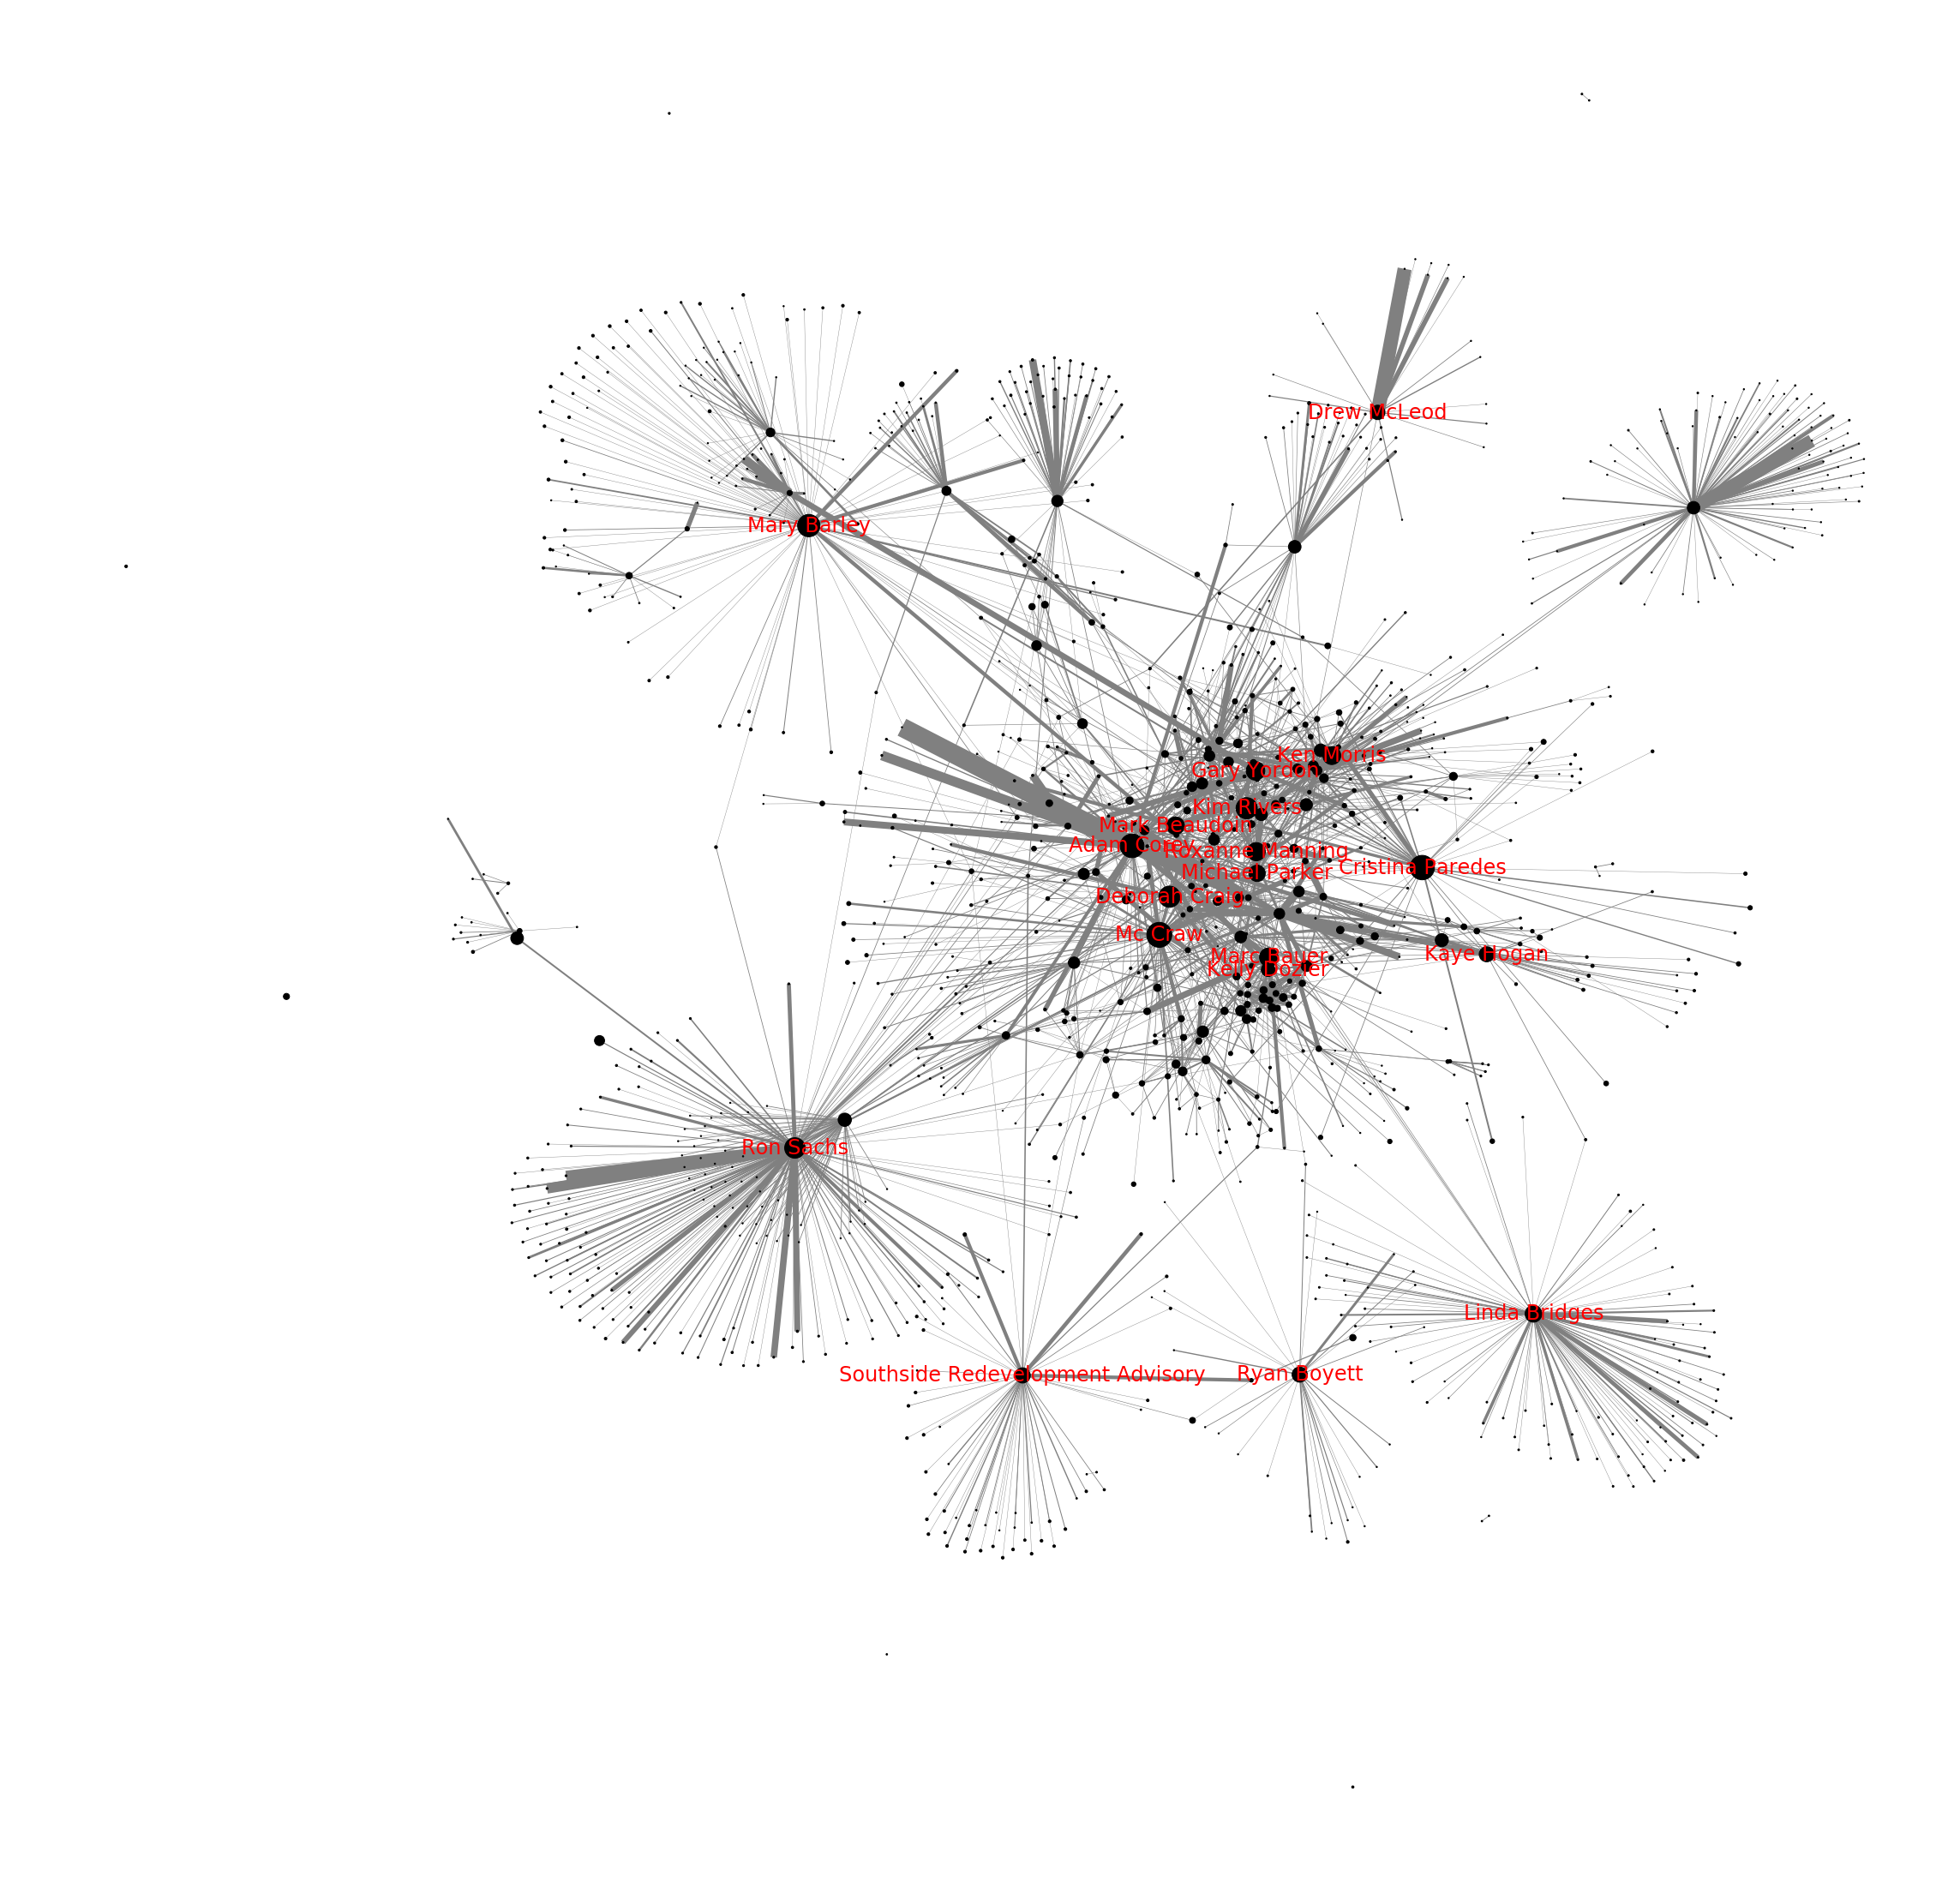

In [14]:
# plotting
G = nx.Graph()
edge_width = []
node_weight_sender = np.sum(sender_to_recipient,axis = 1)
node_weight_recipient = np.sum(sender_to_recipient,axis = 0)
node_weight_total = node_weight_sender + node_weight_recipient 
 
# node_weight is the size of node 
# the node weight has to be in a specific order(in the order of time when the node first added to the graph), 
# cannot just use node_weight_total
node_weight = [] 
for i in range(sender_to_recipient.shape[0]):
    for j in range(i,sender_to_recipient.shape[0]):
        # if there is more than 1 email between these 2 people, add node if haven't add. Add edge.
        if sender_to_recipient[i,j] + sender_to_recipient[j,i] > 1:
            if id_name[i] not in G.nodes():
                G.add_node(id_name[i])
                node_weight.append(node_weight_total[i])
            if id_name[j] not in G.nodes():
                    G.add_node(id_name[j])
                    node_weight.append(node_weight_total[j])
            G.add_edge(id_name[i], id_name[j],weight= 20/(sender_to_recipient[i,j] + sender_to_recipient[j,i] + 0.5*(node_weight_total[i]+ node_weight_total[j])))
            edge_width.append(sender_to_recipient[i,j] + sender_to_recipient[j,i])
print('done adding edges and nodes')

# find who should be labeled
node_have_label = {}
for i in range(sender_to_recipient.shape[0]):
    if node_weight_total[i]>250 and id_name[i] in G.nodes():
        node_have_label[id_name[i]] = id_name[i]

# edge_width is actrually edge strength. Bigger strength will lead to shorter distance
# edge_width = np.sqrt(np.array(edge_width))
edge_width = 0.2*(np.array(edge_width))
print('done adding labels')

plt.figure(figsize=(40,40))
# calculating node positions
pos = nx.spring_layout(G,iterations=30)
print('done calculating position')

nx.draw_networkx_nodes(G, pos, node_size= node_weight,node_color = 'black')
nx.draw_networkx_edges(G, pos, width= edge_width, edge_color = 'grey')
nx.draw_networkx_labels(G, pos, labels= node_have_label, font_size=24, font_color = 'red', font_family='sans-serif')

plt.axis('off')
plt.show()

In [15]:
# test
edge_width.max()

22.400000000000002

{'a': Text(-0.296058,-0.0879575,'a'), 'd': Text(0.61229,-0.0427678,'d')}

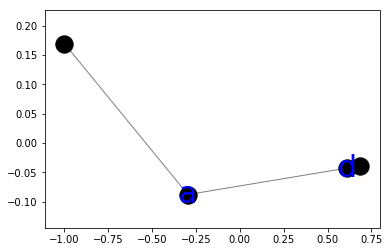

In [16]:
# test
G = nx.Graph()

G.add_edge('d','a',weight = 0.1)
G.add_edge('d','b',weight = 100)
G.add_edge('c','a',weight = 0.1)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos,node_color = 'black')
nx.draw_networkx_edges(G, pos, width=1, edge_color = 'grey')
nx.draw_networkx_labels(G, pos, labels={'a':'a','d':'d'}, font_size=30, font_color='blue',font_family='sans-serif')

# old codes

In [ ]:
# # for i in range(5):
# i = 1
# df_for_plot2 = df_for_plot[df_for_plot['Sent']<datetime(2013+i, 1, 1, 0, 0, 0)]
# df_for_plot3 = df_for_plot2[df_for_plot2['Sent']>datetime(2012+i, 1, 1, 0, 0, 0)]

# G = nx.from_pandas_edgelist(df_for_plot3, 'From','To')
# count = df_for_plot3['From'].append(df_for_plot3['To']).value_counts()
# nodesizes = np.zeros(len(list(G.nodes)))
# for i in range(len(list(G.nodes))):
#     if list(G.nodes)[i] == None:
#         nodesizes[i] = 0
#     else:
#         nodesizes[i] = count[count.index == list(G.nodes)[i]][0]
# index = nodesizes.argsort()[-10:][::-1]
# Top10 = [list(G.nodes)[i] for i in index]
# Top10_val = [nodesizes[i] for i in index]
# print(list(zip(Top10, Top10_val)))

# plt.figure(figsize = (40,30))
# pos = nx.spring_layout(G, k = 0.1, iterations = 30)
# nx.draw_networkx(G, pos, node_size = nodesizes, node_color = 'black', with_labels = True, edge_color='grey')
# plt.axis('off')
# plt.show()

In [ ]:
# l1 = list(G.nodes())
# l2 = big_names
# l3 = [x for x in l1 if x not in l2]
# G.remove_nodes_from(l3)

In [ ]:
# count = df_for_plot3['From'].append(df_for_plot3['To']).value_counts()
# nodesizes = np.zeros(len(list(G.nodes)))
# for i in range(len(list(G.nodes))):
#     if list(G.nodes)[i] == None:
#         nodesizes[i] = 0
#     else:
#         nodesizes[i] = count[count.index == list(G.nodes)[i]][0]
# index = nodesizes.argsort()[-10:][::-1]
# Top10 = [list(G.nodes)[i] for i in index]
# Top10_val = [nodesizes[i] for i in index]
# print(list(zip(Top10, Top10_val)))

# plt.figure(figsize = (40,30))
# pos = nx.spring_layout(G, k = 0.1, iterations = 10)
# nx.draw_networkx(G, pos, node_size = nodesizes, node_color = 'black', with_labels = True, edge_color='grey')
# plt.axis('off')
# plt.savefig('nx_200.png')
# plt.show()